In [1]:
%pylab inline
#sys.path.append('../torchmore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import argparse
import itertools
from itertools import islice

In [3]:
import numpy as np
import pylab
import psutil
import editdistance
import torch
import torch.optim as optim
from torch import nn

In [4]:
import torchmore as tm
import torchtrainers as tt
import webdataset as wds
import tarproclib as tpl

In [5]:
from ocroline import lineest
from ocroline import sequence
from torchmore import helpers
codec = sequence.ascii_codec

Continuum Mechanics


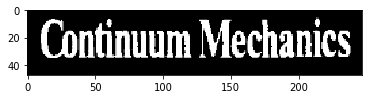

In [6]:
ds = wds.WebDataset("/mdata/tmb-ocr/uw3-dew-training.tgz", extensions="png txt")
for image, txt in ds:
    break
imshow(image)
print(txt)

In [7]:
import math
def batchedbuckets(bs=5, scale=1.5):
    buckets = {}
    def f(data):
        for image, text in data:
            l = image.shape[1]
            r = int(math.floor(math.log(l) / math.log(scale)))
            batched = buckets.get(r, [[], []])
            batched[0].append(image)
            batched[1].append(text)
            #print(l, r, len(batched[0]))
            buckets[r] = batched
            if len(batched[0])>bs:
                yield tuple(batched)
                batched[0] = []
                batched[1] = []
        for r, batched in list(buckets.items()):
            if len(batched[0])==0: continue
            yield tuple(batched)
    return f

(6, 48, 1295) (6, 159, 97)
(6, 48, 1345) (6, 161, 97)
(6, 48, 1405) (6, 163, 97)
(6, 48, 1429) (6, 167, 97)
(6, 48, 1680) (6, 185, 97)
(6, 48, 278) (6, 39, 97)
(6, 48, 1682) (6, 199, 97)
(6, 48, 654) (6, 77, 97)
(6, 48, 1683) (6, 193, 97)
(6, 48, 1445) (6, 173, 97)
(6, 48, 1682) (6, 187, 97)
(6, 48, 433) (6, 53, 97)
(6, 48, 930) (6, 113, 97)
(6, 48, 1446) (6, 165, 97)
(6, 48, 1037) (6, 121, 97)
(6, 48, 951) (6, 119, 97)
(6, 48, 1261) (6, 137, 97)
(6, 48, 1262) (6, 133, 97)
(6, 48, 994) (6, 125, 97)
(6, 48, 951) (6, 123, 97)


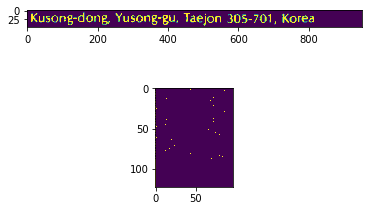

In [8]:
ds = wds.WebDataset("/mdata/tmb-ocr/uw3-dew-training.tgz",
                    pipeline=batchedbuckets(),
                    extensions="png txt")
for image, txt in islice(ds, 0, 20):
    image = sequence.makebatch(image)
    image = np.mean(image, axis=3)
    txt = codec.encode_batch(txt)
    print(image.shape, txt.shape)
subplot(211); imshow(image[0])
subplot(212); imshow(txt[0])
image = torch.Tensor(image).unsqueeze(3)
txt = torch.Tensor(txt)

In [9]:
from torchmore import flex
from torchmore import layers
from importlib import reload
reload(layers)

<module 'torchmore.layers' from '/usr/local/lib/python3.7/dist-packages/torchmore/layers.py'>

In [41]:
reload(layers)
reload(flex)
#flex.verbose = True

ninput = 48
noutput = 97

B, W, H, D = (0, 900), (0, 9000), ninput, (0, 5000)
model = nn.Sequential(
    # reorder to Torch conventions
    layers.Reorder("BHWD", "BDHW"),
    layers.CheckSizes(B, 1, H, W, name="input"),
    # convolutional layers
    flex.Conv2d(100, 3, padding=(1, 1)),  # BDWH
    nn.ReLU(),
    # turn image into sequence
    layers.Reshape(0, [1, 2], 3),
    layers.CheckSizes(B, W, D),
    # run 1D LSTM
    flex.Lstm1(100),
    flex.Conv1d(noutput, 1),
    # reorder
    layers.Reorder("BDW", "BWD"),
    layers.CheckSizes(B, W, noutput, name="output"))

print(model.forward(image).shape)
model.cuda()

optimizer = optim.SGD(model.parameters(),
                      lr=1e-4,
                      momentum=0.9)

torch.Size([6, 951, 97])


In [21]:
help(torch.softmax)

Help on built-in function softmax:

softmax(...)



In [45]:
reload(helpers)

model.cuda()

def train_batch(model, input, target):
    """Train a BHWD input batch against a BWD target batch."""
    assert input.size(0) == target.size(0)
    b, h, w, d = input.size()
    assert d == 1
    input = input.cuda()
    target = target.cuda()
    logits = model.forward(input)
    probs = torch.softmax(logits, 2)
    optimizer.zero_grad()
    deltas, aligned = helpers.ctc_loss(probs, target)
    print(deltas.device, aligned.device)
    optimizer.step()
    return probs, aligned

print(image.shape)
print(txt.shape)
probs, aligned = train_batch(model, image, txt)
print(probs.shape)
print(aligned.shape)

torch.Size([6, 48, 951, 1])
torch.Size([6, 123, 97])
cuda:0 cuda:0
torch.Size([6, 951, 97])
torch.Size([6, 951, 97])


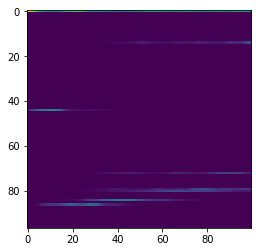

In [49]:
imshow(aligned[0].detach().cpu().numpy().T[:,:100])